# RuleXAI

In this notebook, the data from https://www.kaggle.com/c/titanic is analysed to show the advantages and possibilities of using the RuleXAI library for in-depth analysis of the dataset. It is a popular set, often used in various types of examples, therefore it was decided to use it in this analysis.

## Overview

    I. Initial data analysis and preprocesing
    II. Use of a decision tree from sklearn
    III. Analysis of the decision tree model from the previous point with RuleXAI
    IV. Using the RuleKit library - a versatile tool for rule learning - to generate rule
    V. Analysis with RuleXAI of rules derived with RuleKit
    VI. Summary

## I. Initial data analysis and preprocesing

### 1. Data load
The data used in this analysis comes from the kaggle competition (https://www.kaggle.com/c/titanic). Two datasets were published as part of this competition:   
- training set (train.csv)   
- test set (test.csv)   

According to the competition rules:
"The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.
The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.”

As the purpose of this analysis is to present the RuleXAI library not to take part in the competition, it was decided to use only the data contained in the training set in the further analysis. Therefore, the data from the train.csv file can be split into training and test data, so that it will be possible to evaluate the results obtained without participating in the competition.

In [1]:
import pandas as pd

In [4]:
dataset_path = "./data/titanic_kaggle.csv"
data = pd.read_csv(dataset_path)
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. Dataset overwiev

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
data[['PassengerId', 'Survived', 'Pclass']
     ] = data[['PassengerId', 'Survived', 'Pclass']].astype(str)

In [5]:
numeric_data = data[['Age', 'SibSp', 'Parch', 'Fare']]
caterogical_data = data[['PassengerId', 'Survived', 'Pclass',
                         'Sex', 'Ticket', 'Cabin', 'Embarked']]

In [6]:
numeric_data.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [7]:
caterogical_data.describe()

,PassengerId,Survived,Pclass,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891,204,889
unique,891,2,3,2,681,147,3
top,675,0,3,male,CA. 2343,C23 C25 C27,S
freq,1,549,491,577,7,4,644


### 3. Data preprocessing 

In the first stage of data preprocessing it was decided to only remove the columns for PassengerId, Passenger Name, Ticket type and Cabin. Removing the PassengerId and Passenger Name columns is self-explanatory - in no way does PassengerId or Passenger Name have any bearing on whether a person survived. It would only be possible to derive passenger status from passenger name, as there are markings such as 'Mr.', 'Mrs.', 'Miss.', 'Master.'. In case of tickets, the designations for most tickets vary - 681 unique values out of 891 occurrences. One could extract some information from the tickets from their designations (e.g., whether they begin with a number or a letter). However, historical data would need to be consulted to find out what the ticket designations mean. In the case of cabin designations, as many as 697 values are missing - for this reason it was decided to remove the entire column, as it carries too little information.   
 
Of course, the preliminary data analysis and preprocessing stage itself could have been even more extensive - exploring the relationships between features, examining the impact of individual features, plotting graphs to better understand the data. However, the main purpose of this notebook is not to analyse a given set of data in detail, but only to show the possibilities of using the RuleXAI library. For this reason, some simplifications in the analysis have been decided.

In [8]:
data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
data.reset_index(inplace=True, drop=True)
data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## II. Use of a decision tree from sklearn
In the first stage it was decided to use the decision tree for classification, which is available in the sklearn package and which is also supported by the RuleXAI library.

### 1. Data preparation for decision tree

Since the decision tree algorithm does not support missing values and only operates on numeric data, it was necessary to fill in missing values (for numeric data the median was used, and for categorical data the mode, which is the most frequent value) and dummify. The numerical data could also be rescaled - however, it was decided not to do so to facilitate further analysis, which will be seen later.

In [9]:
data.Age = data.Age.fillna(data.Age.median())
data.Embarked = data.Embarked.fillna(data.Embarked.mode())

data_dummies = pd.get_dummies(data.drop(["Survived"], axis=1))
data_dummies_scaled = data_dummies.copy()

X = data_dummies_scaled
y = data.Survived

### 2. Data split for training and test datasets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, )

### 3. Building and testing the model

A simple decision tree model with default parameters was used, since the main goal is not to get the best possible results, but only to show the use of the RuleXAI library.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1, max_depth=5)
cv = cross_val_score(dt, X_train, y_train, cv=5, scoring = "balanced_accuracy")
print(cv)
print(cv.mean())

[0.69121658 0.82526142 0.73472757 0.72491639 0.8157748 ]
0.7583793541088122


In [12]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [13]:
balanced_accuracy_score(y_test, dt.predict(X_test))

0.7807425259654559

### 4. Determination of the feature importance from the decision tree in the sklearn package

In [14]:
features_importances = pd.DataFrame(columns=["Feature", "Importance"])
features_importances.Feature = X_train.columns
features_importances.Importance = dt.feature_importances_
features_importances = features_importances.sort_values(
    by=["Importance"], ascending=False)
features_importances.reset_index(inplace=True, drop=True)

features_importances

,Feature,Importance
0,Sex_female,0.516327
1,Pclass_3,0.158578
2,Age,0.120043
3,Fare,0.119806
4,SibSp,0.041863
5,Embarked_C,0.028040
6,Pclass_1,0.006695
7,Pclass_2,0.006262
8,Parch,0.002385
9,Sex_male,0.000000


Looking at the importance of the features obtained directly from the decision tree in sklearn, it can be seen that the feature that most distinguished whether someone survived or not was the gender of the person, and more precisely whether the person was a woman or not. However, there is no information on whether the fact that a person was a woman caused survival or death. Knowing the context of the data, it can be concluded that men were gentlemen and they let women go first, therefore it can be concluded that if the person was a woman, she had a better chance of survival. 
The second most important feature that distinguished between survivors and non-survivors was whether the person was traveling in 3rd class. Assuming that the women were saved first, the next selection criterion would be in which class someone traveled. If it was 3rd class, it can be concluded that he was saved last, so there is a high probability that he did not survive. 
Another feature distinguishing whether or not a person survived was the age of the person. It can be assumed that children and the elderly people were saved from people in their prime, who had a better chance of surviving in difficult conditions. 
Another important feature was the amount of fare - it can be concluded that people who paid more for the ticket, traveled in a better class and in better conditions. This coincides with the fact that the survivors and the non-survivors also distinguished very well whether they were traveling in 3rd class or not.  

We can see that the obtained validities of the features coincide with what can be inferred from the historical data and the context of the event. However, without the context, it would be difficult to conclude which feature indicates which class - on the basis of the presented importance of features, one could only obtain information about the separation of classes, and not about which class a given feature indicates. 

### 5. Model generation based on top 50% of features

In [15]:
features_number = 0.5 * features_importances.shape[0]

In [16]:
X_train_sklearn_features = X_train[features_importances.loc[0:features_number-1, "Feature"]]
X_test_sklearn_features = X_test[features_importances.loc[0:features_number-1, "Feature"]]

X_train_sklearn_features

,Sex_female,Pclass_3,Age,Fare,SibSp,Embarked_C
445,0,0,4.0,81.8583,0,0
650,0,1,28.0,7.8958,0,0
172,1,1,1.0,11.1333,1,0
450,0,0,36.0,27.7500,1,0
314,0,0,43.0,26.2500,1,0
...,...,...,...,...,...,...
106,1,1,21.0,7.6500,0,0
270,0,0,28.0,31.0000,0,0
860,0,1,41.0,14.1083,2,0
435,1,0,14.0,120.0000,1,0


In [20]:
dt_sklearn_features = DecisionTreeClassifier(random_state=1, max_depth=5)
cv = cross_val_score(dt_sklearn_features,
                     X_train_sklearn_features, y_train, cv=5, scoring = "balanced_accuracy")
print(cv)
print(cv.mean())

[0.74440807 0.83791965 0.73018712 0.7703456  0.79598662]
0.7757694124203101


In [21]:
dt_sklearn_features.fit(X_train_sklearn_features, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [22]:
balanced_accuracy_score(y_test, dt_sklearn_features.predict(X_test_sklearn_features))

0.7839272393412521

Looking at the results obtained on the training set (in cross-validation) and the test set, one can see that selecting only the most important features according to the ranking obtained with sklearn improved the results obtained. Indeed, the selected features have the greatest impact in distinguishing whether a person survived or not.

## III. Analysis of the decision tree model from the previous point with RuleXAI
### 1. RuleXAI initialisation

In [23]:
from rulexai.explainer import RuleExplainer
explainer = RuleExplainer(model=dt, X=X_train, y=y_train, type="classification")
explainer.explain()

### 2. Presentation of the rules derived from the decision tree

In [24]:
rules = explainer.get_rules()
for rule in rules:
    print(rule)

IF Sex_female = (-inf, 0.5> AND Age = (6.5, 77.0> AND Fare = (-inf, 52.277099609375> AND Pclass_1 = (-inf, 0.5> THEN Survived = {0}
IF Sex_female = (0.5, inf) AND Pclass_3 = (-inf, 0.5> AND Age = (2.5, 49.5> AND Fare = (-inf, 149.035400390625> THEN Survived = {1}
IF Sex_female = (0.5, inf) AND Pclass_3 = (0.5, inf) AND Fare = (-inf, 15.372900009155273> AND Age = (-inf, 36.5> THEN Survived = {1}
IF Sex_female = (-inf, 0.5> AND Age = (6.5, 77.0> AND Fare = (-inf, 52.277099609375> AND Pclass_1 = (0.5, inf) THEN Survived = {0}
IF Sex_female = (0.5, inf) AND Pclass_3 = (0.5, inf) AND Fare = (15.372900009155273, 23.350000381469727> AND Age = (-inf, 36.5> THEN Survived = {1}
IF Sex_female = (-inf, 0.5> AND Age = (6.5, inf) AND Fare = (59.08749961853027, inf) AND Embarked_C = (-inf, 0.5> THEN Survived = {0}
IF Sex_female = (0.5, inf) AND Pclass_3 = (0.5, inf) AND Fare = (23.350000381469727, inf) AND Age = (7.0, inf) THEN Survived = {0}
IF Sex_female = (-inf, 0.5> AND Age = (6.5, inf) AND Fare 

### 3. Importance of features determined by RuleXAI

In [25]:
explainer.feature_importances_

,0 | attributes,0 | importances,1 | attributes,1 | importances
0,Pclass_3,0.895689,Sex_female,1.078293
1,Sex_female,0.844471,Age,0.973953
2,SibSp,0.683045,Fare,0.493457
3,Fare,0.584592,Pclass_3,0.140172
4,Age,0.396833,Pclass_2,0.126684
5,Pclass_2,0.186594,Embarked_C,0.11173
6,Embarked_C,0.101517,SibSp,0.089413
7,Parch,-0.051929,-,-
8,Pclass_1,-0.138521,-,-


Contrary to the importance of the features returned by the decision tree from sklearn, RuleXAI examines the importance of the conditions in the context of the class. In the case of this dataset, the importance of a feature tells us how much a given feature of a person contributed to the assignment of that person to this class. Analysing the ranking of the feature importance, it can be concluded that what most characterised the non-survivors was whether they traveled in grade 3 or not. Second important feature that had impact on non-survival was the gender of the person, and more precisely whether the person was a woman or not. We can also see that the number of siblings had an impact on survival - if someone had many siblings, the parents probably were not able to ensure the safety of all their children. Looking at the survivors, it can be seen that gender had the greatest impact on survival. We can also see that age had big impact on survival - we can draw the conclusions that probably at the beginning, children and the elderly were rescued, because people in their prime had a greater chance of surviving in difficult conditions. Next, whether someone survived depended on the fare - richer people were saved earlier than poorer.

From the feature ranking obtained with RuleXAI, similar conclusions can be drawn as with the feature ranking obtained with sklearn. The advantage of using RuleXAI, however, is that validity of the features is examined in the context of the class. Thanks to this, even without knowing the context, it would be known which feature influenced the assignment of a given class to a given object the most.
An even more in-depth analysis can be performed using the ranking of conditions from the RuleXAI library, as will be shown later in the report

### 4. Model generation based on top 50% of features for each class from RuleXAI

In [26]:
import numpy as np

features_importances_rulexai = explainer.feature_importances_

percent = 50
importances_TOP = []
for j in range(0, features_importances_rulexai.shape[1] + 0, 2):
    class_importances = (
        features_importances_rulexai.iloc[:, j]
        .replace("-", np.nan)
        .dropna()
    )
    class_importances_TOP_number = np.round(
        (percent / 100) * class_importances.shape[0]
    )

    if class_importances_TOP_number == 0:
        class_importances_TOP_number = 1

    class_importances_TOP = class_importances.loc[
        0: class_importances_TOP_number - 1
    ]
    importances_TOP.extend(list(class_importances_TOP))

importances_TOP_list = list(set(importances_TOP))

importances_TOP_list

['Fare', 'Age', 'SibSp', 'Sex_female', 'Pclass_3']

In [27]:
X_train_rulexai_features = X_train[importances_TOP_list]
X_test_rulexai_features = X_test[importances_TOP_list]

X_train_rulexai_features.head(5)


,Fare,Age,SibSp,Sex_female,Pclass_3
445,81.8583,4.0,0,0,0
650,7.8958,28.0,0,0,1
172,11.1333,1.0,1,1,1
450,27.7500,36.0,1,0,0
314,26.2500,43.0,1,0,0


In [28]:
dt_rulexai_features = DecisionTreeClassifier(random_state=1, max_depth=5)
cv = cross_val_score(dt_rulexai_features,
                     X_train_rulexai_features, y_train, cv=5, scoring = "balanced_accuracy")
print(cv)
print(cv.mean())


[0.74440807 0.83791965 0.72110622 0.79403567 0.78065775]
0.7756254727056493


In [29]:
dt_rulexai_features.fit(X_train_rulexai_features, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [30]:
balanced_accuracy_score(y_test, dt_rulexai_features.predict(X_test_rulexai_features))

0.8017157284673209

By selecting 50% of the most important features from the ranking obtained with RuleXAI, it can be seen that compared to the basic set, the results obtained by the decision tree have improved. Comparing these results with the results obtained for the set containing 50% of the most important features from the ranking determined with the use of sklearn, we can see that the results also have improved.

### 5. Further analysis using RuleXAI
#### 5.1 Rule condition importance

Below we present how the importance of the conditions from rules derived from a decision tree can be analysed.

In [31]:
explainer.condition_importances_

,0 | conditions_names,0 | importances,1 | conditions_names,1 | importances
0,"Sex_female = (-inf, 0.5>",1.444185,"Sex_female = (0.5, inf)",1.378759
1,"Pclass_3 = (0.5, inf)",0.856801,"Age = (77.0, inf)",0.404701
2,"SibSp = (3.0, inf)",0.683045,"Age = (-inf, 6.5>",0.339353
3,"Fare = (149.035400390625, 152.5062484741211>",0.455265,"Fare = (52.277099609375, 59.08749961853027>",0.285962
4,"Age = (6.5, 22.0>",0.335094,"Pclass_3 = (-inf, 0.5>",0.280239
5,"Fare = (23.350000381469727, inf)",0.246165,"Age = (3.5, 7.0>",0.254798
6,"Age = (-inf, 2.5>",0.236955,"Pclass_2 = (0.5, inf)",0.126684
7,"Age = (36.5, inf)",0.204974,"Fare = (59.08749961853027, inf)",0.120677
8,"Pclass_2 = (-inf, 0.5>",0.186594,"Embarked_C = (0.5, inf)",0.11173
9,"Fare = (-inf, 31.331250190734863>",0.119378,"SibSp = (-inf, 3.0>",0.089413


Looking at the importance of individual conditions, we can see that the most important condition for a person not surviving is that the person was not a woman, that is, person was a man. On the other hand, the most important condition for a person to survive is that the person was a woman. In this way, we have an explicit confirmation of the hypothesis put forward on the basis of the data context during the analysis of the importance of the features. At this point, note that for categorical variables such as Sex_female, where the feature can be 0 or 1, the rules taken from the decision tree return the condition Sex_female = (-inf, 0.5> when the feature is 0 and Sex_female = (0.5, inf) when the feature takes the value 1.

We also see that the second condition determing that the person did not survive is that they traveled in 3rd grade. This also confirms the hypothesis put forward during the analysis of the feature importance. In the case of the feature importance analysis, we only had information on whether survival was affected by the fact that the person was travelling in 3rd grade. The ranking of conditions gives us an unambiguous confirmation of which decision is impacted by this feature.

The situation is similar with the number of siblings. We can see that if a person had more than 3 siblings, it was more likely that they were in the group of non-survivors. This confirms the hypothesis put forward earlier: with more children, the parents were not able to ensure the safety of all their children.

On the other hand, when looking at the conditions for survivors, it can be seen that in addition to being a woman, the following conditions rank high: Age = (77.0, inf), Age = (-inf, 6.5>. This confirms the hypothesis that children and the elderly people were saved first.

#### 5.2 Local explainability
It is often interesting and important to know on what criteria the model made its decision for a given example. 
In general, thanks to the explanations obtained with XAI methods, the correctness of the model can be verified. Additionally, in some applications of AI it is important that thanks to the use of XAI people affected by the model's decision better understand their situation and have more trust in the model.

This type of explanation is provided by RuleXAI. The explanations take the form of easy to understand and interpret rules, based on which the model makes a decision for a given example, and the importance of the conditions contained in them.

Example:
Age             28.0
SibSp            0.0
Parch            0.0
Fare          7.8958
Pclass_1         0.0
Pclass_2         0.0
Pclass_3         1.0
Sex_female       0.0
Sex_male         1.0
Embarked_C       0.0
Embarked_Q       0.0
Embarked_S       1.0
Survived           0
Name: 650, dtype: object

Rules that covers this example:
IF Sex_female = (-inf, 0.5> AND Age = (6.5, 77.0> AND Fare = (-inf, 52.277099609375> AND Pclass_1 = (-inf, 0.5> THEN Survived = {0}

Importances of the conditions from rules covering the example
             0 | conditions_names  0 | importances
0        Sex_female = (-inf, 0.5>         1.444185
1  Fare = (-inf, 52.277099609375>         0.105219
2               Age = (6.5, 77.0>         0.055288
3          Pclass_1 = (-inf, 0.5>         0.042272


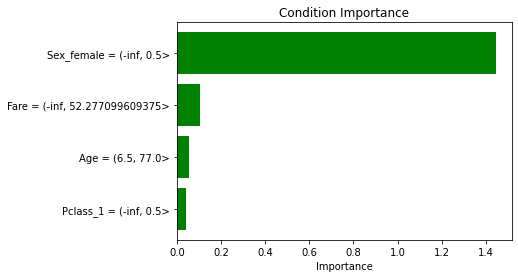

,0 | conditions_names,0 | importances
0,"Sex_female = (-inf, 0.5>",1.444185
1,"Fare = (-inf, 52.277099609375>",0.105219
2,"Age = (6.5, 77.0>",0.055288
3,"Pclass_1 = (-inf, 0.5>",0.042272


In [32]:
example_X = X_train.iloc[1, :]
example_Y = pd.DataFrame(y_train).iloc[1, :]

explainer.local_explainability(example_X, example_Y, plot = True)

Looking at the explanation, we can see that the model classifies a person as a non-survivor based on the rule stating that the person not survived because: was male, was beetwen (6.5, 77.0> years old, paid little for the fare and did not travel in 1st class. The most important of these conditions was that this person was male.

#### 5.3 Creation of a binary dataset
Another functionality provided by RuleXAI is the conversion of the input dataset into a set described by binary features that correspond to specific conditions determined by the model. If for a given condition the example takes the value 0, it means that it does not meet it. If, on the other hand, it takes 1, it means that it satisfies it. This dataset can be used to train other ML models. A significant advantage of such a set is that it has no missing values and only has one type of data (it can be considered as categorical or numerical). Thanks to this, it can be used with any of the available ML models.

In [33]:
X_train_tranformed = explainer.fit_transform(X_train, selector=None)

X_train_tranformed.head(5)

,"Sex_female = (-inf, 0.5>","Age = (6.5, 77.0>","Fare = (-inf, 52.277099609375>","Pclass_1 = (-inf, 0.5>","Sex_female = (0.5, inf)","Pclass_3 = (-inf, 0.5>","Age = (2.5, 49.5>","Fare = (-inf, 149.035400390625>","Pclass_3 = (0.5, inf)","Fare = (-inf, 15.372900009155273>",...,"Parch = (1.5, inf)","Fare = (31.331250190734863, inf)","Age = (-inf, 2.5>","Pclass_2 = (0.5, inf)","Age = (3.5, 7.0>","Fare = (149.035400390625, 152.5062484741211>","Age = (6.5, 22.0>","Age = (77.0, inf)","Fare = (-inf, 31.331250190734863>","Pclass_2 = (-inf, 0.5>"
0,1,0,0,0,0,1,1,1,0,0,...,1,1,0,0,1,0,0,0,0,1
1,1,1,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
2,0,0,1,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,1
3,1,1,1,1,0,1,1,1,0,0,...,1,0,0,1,0,0,0,0,1,0
4,1,1,1,1,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [37]:
X_test_transformed = explainer.transform(X_test)

X_test_transformed.head(5)

,"Sex_female = (-inf, 0.5>","Age = (6.5, 77.0>","Fare = (-inf, 52.277099609375>","Pclass_1 = (-inf, 0.5>","Sex_female = (0.5, inf)","Pclass_3 = (-inf, 0.5>","Age = (2.5, 49.5>","Fare = (-inf, 149.035400390625>","Pclass_3 = (0.5, inf)","Fare = (-inf, 15.372900009155273>",...,"Parch = (1.5, inf)","Fare = (31.331250190734863, inf)","Age = (-inf, 2.5>","Pclass_2 = (0.5, inf)","Age = (3.5, 7.0>","Fare = (149.035400390625, 152.5062484741211>","Age = (6.5, 22.0>","Age = (77.0, inf)","Fare = (-inf, 31.331250190734863>","Pclass_2 = (-inf, 0.5>"
0,1,1,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1,1,1,1,1,0,1,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0
2,1,1,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,1,0,1,1
3,0,0,1,1,1,1,1,1,0,0,...,0,1,0,1,1,0,0,0,0,0
4,0,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,1,1


In [35]:
dt_binary_dataset = DecisionTreeClassifier(random_state=1, max_depth=5)
cv = cross_val_score(dt_binary_dataset,
                     X_train_tranformed, y_train, cv=5, scoring = "balanced_accuracy")
print(cv)
print(cv.mean())

[0.76991271 0.83970831 0.74009356 0.7990524  0.84448161]
0.7986497169696036


In [36]:
dt_binary_dataset.fit(X_train_tranformed, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [38]:
balanced_accuracy_score(y_test, dt_binary_dataset.predict(X_test_transformed))

0.7807425259654559

Looking at the results obtained by the decision tree trained on the created binary set, we can see that it obtains very similar (even slightly better) results than on the original dataset.

#### 5.4 Creation of a binary dataset based on top conditions
RuleXAI allows you to create a binary dataset with a selected percentage of the most important conditions.

In [39]:
X_train_tranformed = explainer.fit_transform(X_train, selector=0.25)

X_train_tranformed.head(5)

,"SibSp = (3.0, inf)","Fare = (52.277099609375, 59.08749961853027>","Pclass_3 = (-inf, 0.5>","Sex_female = (-inf, 0.5>","Sex_female = (0.5, inf)","Age = (3.5, 7.0>","Fare = (149.035400390625, 152.5062484741211>","Age = (6.5, 22.0>","Age = (-inf, 2.5>","Age = (-inf, 6.5>","Pclass_3 = (0.5, inf)","Fare = (23.350000381469727, inf)","Age = (77.0, inf)"
0,0,0,1,1,0,1,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,1,1,1,0,0
3,0,0,1,1,0,0,0,0,0,0,0,1,0
4,0,0,1,1,0,0,0,0,0,0,0,1,0


In [44]:
X_test_transformed = explainer.transform(X_test)

X_test_transformed.head(5)

,"SibSp = (3.0, inf)","Fare = (52.277099609375, 59.08749961853027>","Pclass_3 = (-inf, 0.5>","Sex_female = (-inf, 0.5>","Sex_female = (0.5, inf)","Age = (3.5, 7.0>","Fare = (149.035400390625, 152.5062484741211>","Age = (6.5, 22.0>","Age = (-inf, 2.5>","Age = (-inf, 6.5>","Pclass_3 = (0.5, inf)","Fare = (23.350000381469727, inf)","Age = (77.0, inf)"
0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,1,0,0
3,0,0,1,0,1,1,0,0,0,1,0,1,0
4,0,0,0,0,1,0,0,1,0,0,1,0,0


In [41]:
dt_binary_dataset_with_TOP_conditions = DecisionTreeClassifier(random_state=1, max_depth=5)
cv = cross_val_score(dt_binary_dataset_with_TOP_conditions,
                     X_train_tranformed, y_train, cv=5, scoring = "balanced_accuracy")
print(cv)
print(cv.mean())

[0.77414075 0.86419923 0.76004403 0.79849498 0.81633222]
0.8026422425531315


In [42]:
dt_binary_dataset_with_TOP_conditions.fit(X_train_tranformed,y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [45]:
balanced_accuracy_score(y_test, dt_binary_dataset_with_TOP_conditions.predict(X_test_transformed))

0.7701841969357893

The results obtained on a binary set containing only 25% of all conditions are very similar to those obtained on the entire set. We can see that with fewer data dimensions, similar results can be obtained. Under appropriate conditions, a binary set can be used also to reduce the dimensionality of the set.


#### 5.5 Condition importance based on non-overlapping rule conditions

Below we present another analysis of the importance of the conditions from rules derived from a decision tree. This time the analysis focuses on conditions in rules splitted into base conditions so that individual conditions do not overlap.

In [47]:
explainer.explain(basic_conditions=True)
explainer.condition_importances_

,0 | conditions_names,0 | importances,1 | conditions_names,1 | importances
0,"Sex_female = (-inf, 0.5)",0.709511,"Sex_female = <0.5, inf)",0.593139
1,"SibSp = <3.0, inf)",0.365199,"Age = <77.0, inf)",0.427564
2,"Pclass_3 = <0.5, inf)",0.359394,"Age = <3.5, 6.5)",0.306936
3,"Fare = <149.035400390625, 152.5062484741211)",0.345837,"Fare = <52.277099609375, 59.08749961853027)",0.243723
4,"Age = <7.0, 22.0)",0.205906,"Age = <2.5, 3.5)",0.217869
5,"Fare = (-inf, 15.372900009155273)",0.201038,"Pclass_3 = (-inf, 0.5)",0.129432
6,"Age = (-inf, 2.5)",0.188995,"Age = (-inf, 2.5)",0.127256
7,"Pclass_2 = (-inf, 0.5)",0.186594,"Pclass_2 = <0.5, inf)",0.126684
8,"Fare = <23.350000381469727, 31.331250190734863)",0.094355,"Fare = <59.08749961853027, 149.035400390625)",0.092037
9,"Pclass_3 = (-inf, 0.5)",0.086410,"Fare = <15.372900009155273, 23.350000381469727)",0.09141


Looking at the ranking of conditions that do not overlap, we can come to conclusions similar to the ones drawn from the ranking of overlaping conditions. However, differences can also be seen, e.g. the condition Age = (-inf, 6.5> was high in the ranking of overlapping conditions, suggesting the conclusion that all children under 6.5 were more likely to survive. Nevertheless, when we look at the assessment of the basic conditions, we can see that children aged between 2.5 and 6.5 years [Age = <2.5, 3.5), Age = <3.5, 6.5)] had a good chance of survival, and the condition for children under 2.5 is lower in the ranking. This suggests that infants (under 2.5 years of age) were less likely to survive, possibly due to their dependency.

#### 5.3 Presentation of the rules consisting of non-overlapping base conditions

In [48]:
rules = explainer.get_rules_with_basic_conditions()
for rule in rules:
    print(rule)

IF [Sex_female = (-inf, 0.5)] AND [Age = <6.5, 7.0) OR Age = <7.0, 22.0) OR Age = <22.0, 36.5) OR Age = <36.5, 49.5) OR Age = <49.5, 77.0)] AND [Fare = (-inf, 15.372900009155273) OR Fare = <15.372900009155273, 23.350000381469727) OR Fare = <23.350000381469727, 31.331250190734863) OR Fare = <31.331250190734863, 52.277099609375)] AND [Pclass_1 = (-inf, 0.5)] THEN Survived = {0}
IF [Sex_female = <0.5, inf)] AND [Age = <2.5, 3.5) OR Age = <3.5, 6.5) OR Age = <6.5, 7.0) OR Age = <7.0, 22.0) OR Age = <22.0, 36.5) OR Age = <36.5, 49.5)] AND [Fare = (-inf, 15.372900009155273) OR Fare = <15.372900009155273, 23.350000381469727) OR Fare = <23.350000381469727, 31.331250190734863) OR Fare = <31.331250190734863, 52.277099609375) OR Fare = <52.277099609375, 59.08749961853027) OR Fare = <59.08749961853027, 149.035400390625)] AND [Pclass_3 = (-inf, 0.5)] THEN Survived = {1}
IF [Sex_female = <0.5, inf)] AND [Age = (-inf, 2.5) OR Age = <2.5, 3.5) OR Age = <3.5, 6.5) OR Age = <6.5, 7.0) OR Age = <7.0, 22.

## IV. Using the RuleKit library - a versatile tool for rule learning - to generate rules

In the previous section, the rules obtained from the decision tree were analysed. In this section the analysis is based on rules obtained using the algorithm dedicated for rule-based learning. A set of such algorithms is provided by the RuleKit library.

### 1. Data preparation for RuleKit
RuleKit supports missing values and categorical data, so the step of preparing data specifically for this algorithm is not necessary - what was done in Section I is sufficient. The only thing to remember is that RuleKit accepts missing values for numeric columns as nan, while for categorical columns as None. For this reason it was necessary to change the missing values in the Embarked column from nan to None.

In [49]:
import numpy as np

X = data.drop(["Survived"], axis=1)
X.Embarked.replace(np.nan, None, inplace = True)
y = data.Survived

X.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


### 2. Data split for training and test datasets

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

### 3. Building and testing the model

In [51]:
from sklearn.model_selection import cross_val_score
from rulekit import RuleKit
from rulekit.classification import RuleClassifier
from rulekit.params import Measures

RuleKit.init()

rc = RuleClassifier(
    induction_measure=Measures.C2,
    pruning_measure=Measures.C2,
    voting_measure=Measures.C2,
    min_rule_covered=5
)
cv = cross_val_score(rc, X_train, y_train, cv=5, scoring = "balanced_accuracy")
print(cv)
print(cv.mean())


[0.73958333 0.88666667 0.70763889 0.8027027  0.82383191]
0.7920847009219034


In [52]:
rc.fit(X_train, y_train)

In [53]:
balanced_accuracy_score(y_test, rc.predict(X_test))

0.749756125552304

The quality of the rule model is similar to that obtained for the decision tree. By controlling the rule model induction parameters even better results could be obtained, but this is not the subject of this notebook.

### 4. Presentation of the rules obtained by RuleKit

In [54]:
for rule in rc.model.rules:
    print(rule)

IF Age = (-inf, 0.92) THEN Survived = {1}
IF Pclass = {2} AND Sex = {female} THEN Survived = {1}
IF Parch = (-inf, 1.50) AND Sex = {female} AND Fare = <29.36, inf) THEN Survived = {1}
IF Pclass = {1} AND Sex = {female} AND Age = <8, inf) AND Fare = <29.36, inf) THEN Survived = {1}
IF Parch = (-inf, 1.50) AND Sex = {female} AND SibSp = (-inf, 2.50) AND Fare = <21.72, inf) THEN Survived = {1}
IF Sex = {female} AND SibSp = <0.50, inf) AND Age = <27.50, inf) AND Fare = <15.98, 22.34) THEN Survived = {1}
IF Parch = (-inf, 1.50) AND Sex = {female} AND SibSp = (-inf, 2.50) AND Fare = <10.48, inf) THEN Survived = {1}
IF Parch = (-inf, 3.50) AND Sex = {female} AND SibSp = (-inf, 0.50) AND Fare = <10.83, inf) THEN Survived = {1}
IF Parch = (-inf, 1.50) AND Sex = {female} AND Fare = <6.99, inf) THEN Survived = {1}
IF SibSp = (-inf, 2) AND Age = <8, 43.50) AND Fare = <82.66, inf) THEN Survived = {1}
IF SibSp = (-inf, 1.50) AND Age = <3, 62) AND Fare = <74.38, inf) THEN Survived = {1}
IF SibSp = (-

## V. Analysis with RuleXAI of rules derived with RuleKit

### 1. Initialisation and explaination

In [55]:
from rulexai.explainer import RuleExplainer
explainer = RuleExplainer(model=rc, X=X_train, y=y_train, type="classification")
explainer.explain()

### 2. Feature importance determined by RuleXAI

In [56]:
explainer.feature_importances_

,1 | attributes,1 | importances,0 | attributes,0 | importances
0,Sex,2.153698,Fare,2.745895
1,Fare,1.834094,Sex,1.481201
2,Age,1.518890,Pclass,0.731226
3,Pclass,0.437313,Parch,0.571222
4,SibSp,0.161694,Age,0.550799
5,Embarked,0.135499,SibSp,0.513230
6,Parch,0.089201,Embarked,0.205367


### 3. Rule condition importance

In [57]:
explainer.condition_importances_

,1 | conditions_names,1 | importances,0 | conditions_names,0 | importances
0,Sex = {female},2.153698,Sex = {male},1.481201
1,"Age = (-inf, 0.92)",0.510823,Pclass = {3},0.731226
2,"Age = <2.5, 6.5)",0.426003,"Fare = <2.01, 7.13)",0.519133
3,"Age = (-inf, 6.5)",0.359902,"Fare = <9.41, 10.48)",0.517857
4,Pclass = {2},0.275112,"Fare = (-inf, 10.48)",0.516811
5,"Fare = <82.66, inf)",0.267579,"SibSp = <4.5, inf)",0.515306
6,"Fare = <52.28, 143.59)",0.257940,"Parch = <3.5, inf)",0.508929
7,"Fare = <29.85, inf)",0.247359,"Fare = (-inf, 7.13)",0.482425
8,"Fare = <74.38, inf)",0.239459,Embarked = {S},0.205367
9,"Fare = <10.48, inf)",0.213492,"Fare = <7.87, 8.08)",0.20006


Looking at the importance of the features and conditions obtained from the rules determined by RuleKit, one can come to conclusions similar to those obtained for rules determined from the decision tree. The main difference is that in rules generated by RuleKit, the fare also plays an important role - 
the lower the fare, the person traveled in a lower class what determined their survival.

### 4. Creation of a binary dataset based on top conditions

In [59]:
X_train_tranformed = explainer.fit_transform(X_train, selector=25)

X_train_tranformed.head(5)

,"Fare = <52.28, 143.59)","Fare = <29.85, inf)","Fare = <2.01, 7.13)",Pclass = {1},"Age = (-inf, 0.92)","Parch = <3.5, inf)","Fare = <74.38, inf)","Age = <2.5, 6.5)",Sex = {male},Pclass = {3},"Fare = <10.48, inf)","Fare = <9.41, 10.48)","Fare = (-inf, 10.48)","SibSp = <4.5, inf)","Fare = (-inf, 7.13)",Sex = {female},Pclass = {2},"Fare = <82.66, inf)","Age = (-inf, 6.5)"
0,1,1,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


In [60]:
X_test_transformed = explainer.transform(X_test)

X_test_transformed.head(5)

,"Fare = <52.28, 143.59)","Fare = <29.85, inf)","Fare = <2.01, 7.13)",Pclass = {1},"Age = (-inf, 0.92)","Parch = <3.5, inf)","Fare = <74.38, inf)","Age = <2.5, 6.5)",Sex = {male},Pclass = {3},"Fare = <10.48, inf)","Fare = <9.41, 10.48)","Fare = (-inf, 10.48)","SibSp = <4.5, inf)","Fare = (-inf, 7.13)",Sex = {female},Pclass = {2},"Fare = <82.66, inf)","Age = (-inf, 6.5)"
0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1
4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0


A binary dataset created in this way can be used to create a classifier using another machine learning algorithm. The advantage of this approach is that RuleKit has created rules on a set containing null values and containing both numeric and categorical variables. However, the prepared dataset consists only of numerical values 0 and 1 determining whether a given condition has been met and does not contain empty values. Therefore, you can easily use algorithms that deal only with numerical values and do not handle missing values, such as RandomForest as shown below.

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
cv = cross_val_score(rf, X_train_tranformed,
                     y_train, cv=5, scoring = "balanced_accuracy")
print(cv)
print(cv.mean())


[0.7570922  0.86241057 0.703082   0.73188406 0.8113155 ]
0.7731568645642581


In [64]:
rf.fit(X_train_tranformed, y_train)

RandomForestClassifier(random_state=1)

In [65]:
balanced_accuracy_score(y_test, rf.predict(X_test_transformed))

0.7861077638147702

## VI. Summary
The presented analysis shows how the RuleXAI library may be used for data analysis and model explanation. Explanations, both global and local, are performed using the generated rule-based model representation.